In [738]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import *
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

# Loading the Data

In [790]:
desc = pd.read_excel('data-dictionary.xlsx', index_col=0)
data_features = pd.read_csv('transactions_obf.csv')
data_labels = pd.read_csv('labels_obf.csv')
fraud_transactions = data_labels['eventId'].tolist()

# Creating Target Variable

In [791]:
data_features.loc[data_features['eventId'].isin(fraud_transactions) , 'isFraud'] = 1
data_features.loc[data_features['eventId'].isin(fraud_transactions) == False , 'isFraud'] = 0

In [792]:
counts = data_features['isFraud'].value_counts()
print(f'Out of the total {len(data_features)} transactions, {dict(counts).get(0)} are genuine and {dict(counts).get(1)} are fraud.')


Out of the total 118621 transactions, 117746 are genuine and 875 are fraud.


# Dataset Visualisation

# transaction time

In [793]:
# transaction time has a very high cardinality with 99.6% unique values. It should not be used to train the model as it does not provide much information ot the model. Instead I have extracted the hour from the time and created a new feature which signifies the part of the day when the transaction was made. This can be a great feature as the model can spot patterns to identify suspicious behaviour in unusual time of the day. 

In [794]:
data_features['transactionTime'] = pd.to_datetime(data_features['transactionTime'])

In [795]:
data_features['transactionTime'][1000].hour

10

In [796]:
# def get_pod(x):
#     for i in range (len(data_features)):
#         if (x[i].hour > 4) and (x[i].hour <= 8):
#             return 'Early Morning'
#         elif (x[i].hour > 8) and (x[i].hour <= 12 ):
#             return 'Morning'
#         elif (x[i].hour > 12) and (x[i].hour <= 16):
#             return'Noon'
#         elif (x[i].hour > 16) and (x[i].hour <= 20) :
#             return 'Eve'
#         elif (x[i].hour > 20) and (x[i].hour <= 24):
#             return'Night'
#         elif (x[i].hour <= 4):
#             return'Late Night'

In [797]:
def get_pod(x):
    if (x.hour > 4) and (x.hour <= 8):
        return 'Early Morning'
    elif (x.hour > 8) and (x.hour <= 12 ):
        return 'Morning'
    elif (x.hour > 12) and (x.hour <= 16):
        return'Noon'
    elif (x.hour > 16) and (x.hour <= 20) :
        return 'Eve'
    elif (x.hour > 20) and (x.hour <= 24):
        return'Night'
    elif (x.hour <= 4):
        return'Late Night'

In [798]:
data_features['transactionTime'] = pd.to_datetime(data_features['transactionTime'])
data_features['part_of_day'] = data_features['transactionTime'].apply(get_pod)
pod_dummies = pd.get_dummies(data_features['part_of_day'],prefix = 'tx_at')
data_features = pd.concat([data_features,pod_dummies],axis=1)
data_features = data_features.drop(columns=['transactionTime','part_of_day'])


In [799]:
data_features

,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud,tx_at_Early Morning,tx_at_Eve,tx_at_Late Night,tx_at_Morning,tx_at_Night,tx_at_Noon
0,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0.0,0,0,1,0,0,0
1,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0.0,0,0,1,0,0,0
2,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0.0,0,0,1,0,0,0
3,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0.0,0,0,1,0,0,0
4,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0.0,0,0,0,0,1,0
118617,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0.0,0,0,0,0,1,0
118618,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0.0,0,0,0,0,1,0
118619,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,0.0,0,0,1,0,0,0


# eventID

In [800]:
# similar to transaction time 'eventId' has a very high cardinality as well with 100% unique values and it should not be used to train the model. Hence we drop this column from our feature set.

In [801]:
data_features = data_features.drop(columns=['eventId'])

# Account Number

In [802]:
# Account Number has just 766 unique values which is 0.6% of the total values. Account number as it is can't be a great predictor as it is just an id and does not provide any information. But instead 
# the frequency of the account numbers can be calculated and used as a feature. The number of transactions by the same account is definitely a great predictor for fraud detection systems.
# High number of transactions from the same account can signal towards a probable fraud.

In [803]:
acc_freq = data_features.accountNumber.value_counts()
acc_freq = pd.DataFrame(acc_freq)
acc_freq["name"] = acc_freq.index
acc_freq.rename(columns = {'accountNumber':'acc_freq', 'name':'accountNumber'}, inplace = True)
data_features = data_features.merge(acc_freq, on = 'accountNumber')
data_features = data_features.drop(columns=['accountNumber'])
data_features

,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud,tx_at_Early Morning,tx_at_Eve,tx_at_Late Night,tx_at_Morning,tx_at_Night,tx_at_Noon,acc_freq
0,b76d06,5968,826,CR0,1,10.72,7500,0.0,0,0,1,0,0,0,362
1,46322b,4816,826,L39LQ,81,274.92,8500,0.0,1,0,0,0,0,0,362
2,46322b,4816,826,L39LQ,81,11.00,8500,0.0,1,0,0,0,0,0,362
3,71d326,5968,826,UB11,1,8.45,7500,0.0,0,0,1,0,0,0,362
4,b76d06,5968,826,CR0,1,11.98,8500,0.0,0,0,0,0,1,0,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,c647f3,6011,826,PR7,5,149.00,1500,0.0,0,0,0,1,0,0,6
118617,c647f3,6011,826,PR7,5,149.00,1500,0.0,0,0,0,1,0,0,6
118618,f513f2,5977,826,PR7,5,29.08,1500,0.0,0,0,0,0,0,1,6
118619,c647f3,6011,826,PR7,5,249.00,1500,0.0,0,0,1,0,0,0,6


# Merchant Id

In [804]:
# Merchant Id is a unique id of the merchant and has 33327 unique values. It should not be used as it is while training the model because of its very high cardinality. Frequency of the merchant id could be used but there is a high chance that it gets correlated with 'mcc' as similar merchant ids will always have similar mcc.
#  Hence we drop this column from our feature set.

In [805]:
data_features = data_features.drop(columns=['merchantId'])

# MCC


In [806]:
# MCC represents the merchant category code of the merchant. It specifies the type of goods or services the merchant provides. It has a high cardinality as well and hence we use the frequency of MCC instead of the MCC codes. 
# The frequency will represent the number of times a specific type of service or goods category appeared. 

In [807]:
mcc_freq = data_features.mcc.value_counts()
mcc_freq = pd.DataFrame(mcc_freq)
mcc_freq["mcc_code"] = mcc_freq.index
mcc_freq.rename(columns = {'mcc':'mcc_freq', 'mcc_code':'mcc'}, inplace = True)
data_features = data_features.merge(mcc_freq, on = 'mcc')
data_features = data_features.drop(columns=['mcc'])

# Merchant Country

In [808]:
# It is the country of the merchant who charged for the transaction. It contains 82 different countries. Using label encoder 

In [809]:
merchant_country_freq = pd.DataFrame(data_features.merchantCountry.value_counts())
merchant_country_freq["mc"] = merchant_country_freq.index
country_list = merchant_country_freq.loc[merchant_country_freq.merchantCountry>100,"mc"] # extracting countires whose transaction frequency is more than 100
data_features.loc[data_features["merchantCountry"].isin(country_list)==False,"merchantCountry"]="low_freq_countires" # marking rest countries as "low_freq_countries"

mc_dummies = pd.get_dummies(data_features['merchantCountry'],prefix = 'mc')
data_features = pd.concat([data_features,mc_dummies],axis=1)
data_features = data_features.drop(columns=['merchantCountry'])


In [810]:
data_features

,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud,tx_at_Early Morning,tx_at_Eve,tx_at_Late Night,tx_at_Morning,tx_at_Night,...,mc_292,mc_372,mc_380,mc_442,mc_528,mc_724,mc_756,mc_826,mc_840,mc_low_freq_countires
0,CR0,1,10.72,7500,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,UB11,1,8.45,7500,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,CR0,1,11.98,8500,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,TS17,1,25.22,7500,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,UB11,1,8.38,7500,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,NaN,1,122.91,500,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
118617,NaN,1,309.67,1500,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
118618,NaN,90,38.26,1500,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
118619,74133,81,1230.04,8500,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Merchant Zip

In [811]:
# It is the zip code of the postal address of the merchant. This column cointains 23005 missing values and the best method is to drop the column.
print('The number of na values for the feature "merchantZip" is', data_features.apply(lambda x : x.isnull().sum()).to_dict().get('merchantZip'))

The number of na values for the feature "merchantZip" is 23005


In [812]:
data_features = data_features.drop(columns=['merchantZip'])

In [813]:
data_features

,posEntryMode,transactionAmount,availableCash,isFraud,tx_at_Early Morning,tx_at_Eve,tx_at_Late Night,tx_at_Morning,tx_at_Night,tx_at_Noon,...,mc_292,mc_372,mc_380,mc_442,mc_528,mc_724,mc_756,mc_826,mc_840,mc_low_freq_countires
0,1,10.72,7500,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,8.45,7500,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,11.98,8500,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,25.22,7500,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,8.38,7500,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,1,122.91,500,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
118617,1,309.67,1500,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
118618,90,38.26,1500,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
118619,81,1230.04,8500,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


# POS Entry Mode

In [814]:
# It represents the point of sale entry mode and there are just 10 distinct values hence we should use a one hot encoder. This can be done using the 
# get_dummies function from pandas.

In [815]:
data_features['posEntryMode'].value_counts()

5     70228
81    35832
1     10568
90     1202
7       637
80       92
79       31
2        16
0        11
91        4
Name: posEntryMode, dtype: int64

In [816]:
pos_dummies = pd.get_dummies(data_features['posEntryMode'],prefix='pos_mode')
data_features = pd.concat([data_features,pos_dummies],axis=1)
data_features = data_features.drop(columns=['posEntryMode'])
data_features

,transactionAmount,availableCash,isFraud,tx_at_Early Morning,tx_at_Eve,tx_at_Late Night,tx_at_Morning,tx_at_Night,tx_at_Noon,acc_freq,...,pos_mode_0,pos_mode_1,pos_mode_2,pos_mode_5,pos_mode_7,pos_mode_79,pos_mode_80,pos_mode_81,pos_mode_90,pos_mode_91
0,10.72,7500,0.0,0,0,1,0,0,0,362,...,0,1,0,0,0,0,0,0,0,0
1,8.45,7500,0.0,0,0,1,0,0,0,362,...,0,1,0,0,0,0,0,0,0,0
2,11.98,8500,0.0,0,0,0,0,1,0,362,...,0,1,0,0,0,0,0,0,0,0
3,25.22,7500,0.0,0,0,0,0,1,0,362,...,0,1,0,0,0,0,0,0,0,0
4,8.38,7500,0.0,0,0,0,0,1,0,362,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,122.91,500,0.0,0,0,0,0,0,1,243,...,0,1,0,0,0,0,0,0,0,0
118617,309.67,1500,0.0,0,0,0,1,0,0,243,...,0,1,0,0,0,0,0,0,0,0
118618,38.26,1500,0.0,0,1,0,0,0,0,243,...,0,0,0,0,0,0,0,0,1,0
118619,1230.04,8500,0.0,0,0,0,0,0,1,37,...,0,0,0,0,0,0,0,1,0,0


# Transaction Amount

In [817]:
# This column contains a certain number of negative values which are not veyr high in magnitude. The minimum tranasction amount is "-0.15". 
# We can either reomove these 183 values or make them zero. It wont make a huge difference if I perform any of these two methods
# but leaving the negative values as it is can degrade the performance of our classifier. I chose to remove the observations as -ve transaction values don't make sense
# and making them zero without any strong reason would not make any sense. As far as the skewness of this feature is concerned, I do not plan to use a parametric model 
# hence transforming the values according to a specific distribution won't make sense. 

In [818]:
neg_indexes = data_features[ data_features['transactionAmount'] < 0 ].index
data_features.drop(neg_indexes , inplace=True)

In [819]:
data_features['isFraud'].value_counts()

0.0    117566
1.0       872
Name: isFraud, dtype: int64

# Available Cash

In [820]:
# This column seems to be perfectly fine and can be used in our prediction models as it is. 

# Data set balance

Indeed, with only 0.74% transactions that are fraudulent, a classifier that predicts every transaction to be not fraudulent will achieve accuracy score of 99.26%. However, such a classifier is valueless. Therefore, in the cases when classes are imbalanced, metrics other than accuracy should be considered. These metrics include precision, recall and a combination of these two metrics (F2).



In [821]:
data_features['transactionAmount'] = np.log(data_features['transactionAmount'] + 0.01)

In [825]:
from sklearn.preprocessing import StandardScaler
mm = StandardScaler()
data_features['acc_freq'] = mm.fit_transform(data_features[['acc_freq']])
data_features['mcc_freq'] = mm.fit_transform(data_features[['mcc_freq']])

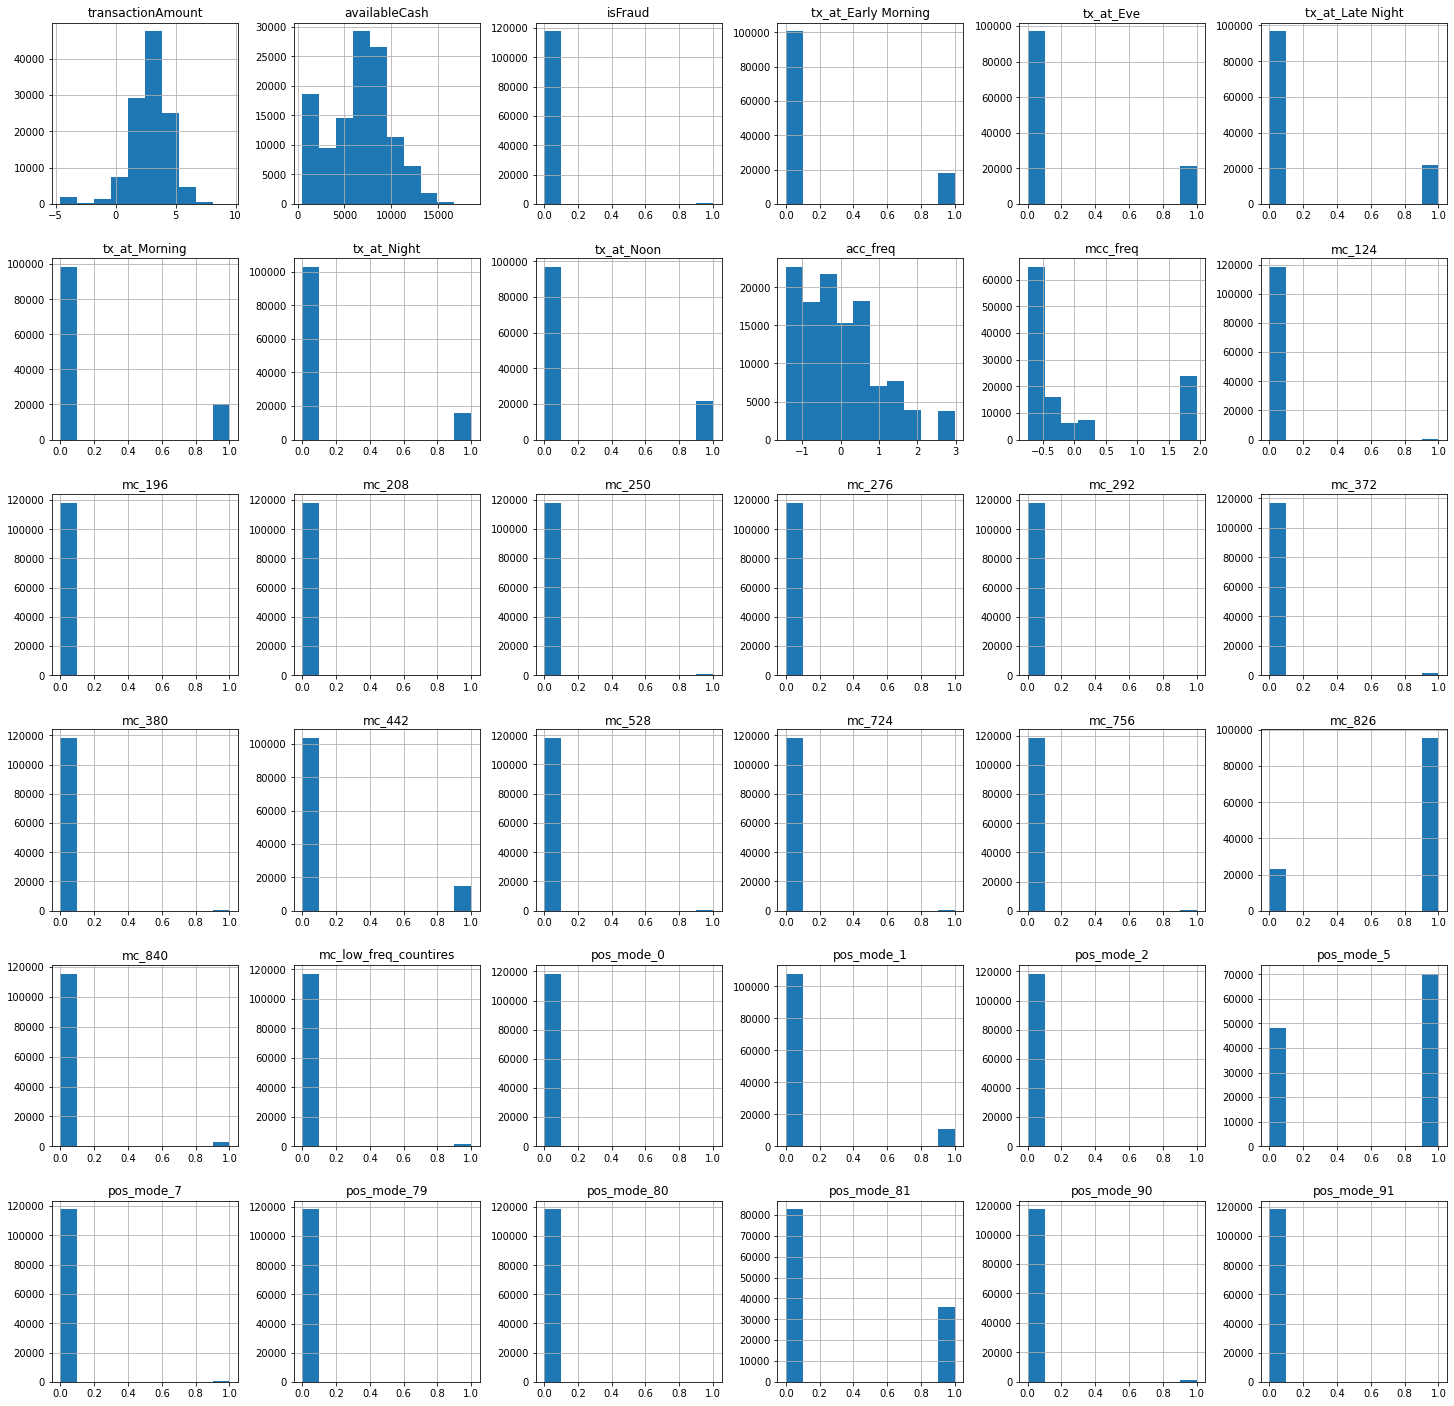

In [826]:
data_features.hist(figsize = (25,25))
plt.show()

In [827]:
X = data_features.drop(columns=['isFraud'])
y = data_features['isFraud']

In [828]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [829]:
from imblearn.over_sampling import SMOTE

In [830]:
def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

def upsample_SMOTE(X_train, y_train, target_var, ratio):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    resampling = X_train_sm.copy()
    resampling[target_var] = y_train_sm.values
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))

    return X_train_sm, y_train_sm

In [868]:
maj_class, min_class = resamplingDataPrep(X_train,y_train,'isFraud')

X_train_sm, y_train_sm = upsample_SMOTE(X_train,y_train,'is_Fraud',0.5)

majority_class: 82296
minority_class: 610
majority_class: 82296
minority_class: 41148


In [869]:
# The penalty for mislabeling a fraud transaction as legitimate is having a user’s money stolen, which the credit card company
# typically reimburses. On the other hand, the penalty for mislabeling a legitimate transaction as fraud is having the user frozen
# out of their finances and unable to make payments. Balancing the data keeping mind that we need to catch most of the fraudulent
# transactions and have the least number of false positives. I will be using 

In [870]:
# the target variable "isFraud" is highly imbalanced. In such case the classifier will favour the majority classs start generating false predictions.
# Hence we upsample the minority class using synthetic monetory upsampling technique. 

In [871]:

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_sm, y_train_sm) 

RandomForestClassifier()

In [872]:
y_pred = rfc.predict(X_test)

In [873]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35270
         1.0       0.70      0.52      0.60       262

    accuracy                           0.99     35532
   macro avg       0.85      0.76      0.80     35532
weighted avg       0.99      0.99      0.99     35532



In [874]:
metrics.confusion_matrix(y_test, y_pred)

array([[35213,    57],
       [  126,   136]])